In [1]:
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR

In [2]:
# Check for GPU
device = torch.device('cpu')
print("Running on ", device, " cores")

# Load the data
FirstData = np.load("fullsky4catsgaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
ypostencode = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(np.argmax(ypostencode, axis=1))
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer, schedular for learning rate
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)  # Moves the model to the GPU

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(y_batch.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 400
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')
    if test_accuracy > 0.97:
        break
torch.save(model.state_dict(), "star_classifier_Exp2.pth") # Save the model

Running on  cpu  cores


Epoch 1/400: 100%|██████████| 142/142 [00:01<00:00, 110.55batch/s, Loss=4.4885]



Test Accuracy after Epoch 1: 0.8081


Epoch 2/400: 100%|██████████| 142/142 [00:00<00:00, 160.68batch/s, Loss=3.5606]



Test Accuracy after Epoch 2: 0.8530


Epoch 3/400: 100%|██████████| 142/142 [00:01<00:00, 123.09batch/s, Loss=3.5215]



Test Accuracy after Epoch 3: 0.8793


Epoch 4/400: 100%|██████████| 142/142 [00:00<00:00, 143.42batch/s, Loss=3.4981]



Test Accuracy after Epoch 4: 0.8907


Epoch 5/400: 100%|██████████| 142/142 [00:00<00:00, 150.61batch/s, Loss=3.4517]



Test Accuracy after Epoch 5: 0.8818


Epoch 6/400: 100%|██████████| 142/142 [00:01<00:00, 106.00batch/s, Loss=3.4308]



Test Accuracy after Epoch 6: 0.9106


Epoch 7/400: 100%|██████████| 142/142 [00:00<00:00, 158.81batch/s, Loss=3.4456]



Test Accuracy after Epoch 7: 0.8710


Epoch 8/400: 100%|██████████| 142/142 [00:01<00:00, 113.11batch/s, Loss=3.4370]



Test Accuracy after Epoch 8: 0.9237


Epoch 9/400: 100%|██████████| 142/142 [00:01<00:00, 136.04batch/s, Loss=3.4228]



Test Accuracy after Epoch 9: 0.8965


Epoch 10/400: 100%|██████████| 142/142 [00:00<00:00, 142.57batch/s, Loss=3.4434]



Test Accuracy after Epoch 10: 0.9260


Epoch 11/400: 100%|██████████| 142/142 [00:01<00:00, 115.63batch/s, Loss=3.4010]



Test Accuracy after Epoch 11: 0.9225


Epoch 12/400: 100%|██████████| 142/142 [00:00<00:00, 161.99batch/s, Loss=3.3895]



Test Accuracy after Epoch 12: 0.9331


Epoch 13/400: 100%|██████████| 142/142 [00:01<00:00, 124.36batch/s, Loss=3.4082]



Test Accuracy after Epoch 13: 0.9153


Epoch 14/400: 100%|██████████| 142/142 [00:00<00:00, 145.51batch/s, Loss=3.3698]



Test Accuracy after Epoch 14: 0.9340


Epoch 15/400: 100%|██████████| 142/142 [00:01<00:00, 115.11batch/s, Loss=3.3710]



Test Accuracy after Epoch 15: 0.9500


Epoch 16/400: 100%|██████████| 142/142 [00:01<00:00, 115.75batch/s, Loss=3.4214]



Test Accuracy after Epoch 16: 0.9175


Epoch 17/400: 100%|██████████| 142/142 [00:00<00:00, 150.22batch/s, Loss=3.3783]



Test Accuracy after Epoch 17: 0.9086


Epoch 18/400: 100%|██████████| 142/142 [00:01<00:00, 117.69batch/s, Loss=3.3884]



Test Accuracy after Epoch 18: 0.9261


Epoch 19/400: 100%|██████████| 142/142 [00:01<00:00, 110.91batch/s, Loss=3.3738]



Test Accuracy after Epoch 19: 0.8949


Epoch 20/400: 100%|██████████| 142/142 [00:00<00:00, 154.27batch/s, Loss=3.3719]



Test Accuracy after Epoch 20: 0.9379


Epoch 21/400: 100%|██████████| 142/142 [00:01<00:00, 110.53batch/s, Loss=3.3659]



Test Accuracy after Epoch 21: 0.9563


Epoch 22/400: 100%|██████████| 142/142 [00:01<00:00, 120.80batch/s, Loss=3.3421]



Test Accuracy after Epoch 22: 0.9402


Epoch 23/400: 100%|██████████| 142/142 [00:00<00:00, 153.72batch/s, Loss=3.3576]



Test Accuracy after Epoch 23: 0.9501


Epoch 24/400: 100%|██████████| 142/142 [00:01<00:00, 115.63batch/s, Loss=3.3584]



Test Accuracy after Epoch 24: 0.9313


Epoch 25/400: 100%|██████████| 142/142 [00:00<00:00, 144.22batch/s, Loss=3.3536]



Test Accuracy after Epoch 25: 0.9440


Epoch 26/400: 100%|██████████| 142/142 [00:01<00:00, 118.24batch/s, Loss=3.3636]



Test Accuracy after Epoch 26: 0.9563


Epoch 27/400: 100%|██████████| 142/142 [00:01<00:00, 128.91batch/s, Loss=3.3943]



Test Accuracy after Epoch 27: 0.9310


Epoch 28/400: 100%|██████████| 142/142 [00:01<00:00, 128.25batch/s, Loss=3.3384]



Test Accuracy after Epoch 28: 0.9515


Epoch 29/400: 100%|██████████| 142/142 [00:01<00:00, 116.55batch/s, Loss=3.3522]



Test Accuracy after Epoch 29: 0.9544


Epoch 30/400: 100%|██████████| 142/142 [00:00<00:00, 143.72batch/s, Loss=3.3544]



Test Accuracy after Epoch 30: 0.9289


Epoch 31/400: 100%|██████████| 142/142 [00:01<00:00, 115.41batch/s, Loss=3.3455]



Test Accuracy after Epoch 31: 0.9249


Epoch 32/400: 100%|██████████| 142/142 [00:00<00:00, 144.66batch/s, Loss=3.3633]



Test Accuracy after Epoch 32: 0.9347


Epoch 33/400: 100%|██████████| 142/142 [00:01<00:00, 139.76batch/s, Loss=3.3553]



Test Accuracy after Epoch 33: 0.9178


Epoch 34/400: 100%|██████████| 142/142 [00:01<00:00, 115.14batch/s, Loss=3.3522]



Test Accuracy after Epoch 34: 0.9332


Epoch 35/400: 100%|██████████| 142/142 [00:01<00:00, 131.82batch/s, Loss=3.3538]



Test Accuracy after Epoch 35: 0.9265


Epoch 36/400: 100%|██████████| 142/142 [00:01<00:00, 115.77batch/s, Loss=3.3432]



Test Accuracy after Epoch 36: 0.9220


Epoch 37/400: 100%|██████████| 142/142 [00:01<00:00, 140.63batch/s, Loss=3.3793]



Test Accuracy after Epoch 37: 0.9313


Epoch 38/400: 100%|██████████| 142/142 [00:00<00:00, 148.86batch/s, Loss=3.3296]



Test Accuracy after Epoch 38: 0.9493


Epoch 39/400: 100%|██████████| 142/142 [00:01<00:00, 112.38batch/s, Loss=3.3405]



Test Accuracy after Epoch 39: 0.9209


Epoch 40/400: 100%|██████████| 142/142 [00:00<00:00, 144.53batch/s, Loss=3.3270]



Test Accuracy after Epoch 40: 0.9519


Epoch 41/400: 100%|██████████| 142/142 [00:01<00:00, 120.22batch/s, Loss=3.3196]



Test Accuracy after Epoch 41: 0.9528


Epoch 42/400: 100%|██████████| 142/142 [00:00<00:00, 143.43batch/s, Loss=3.3487]



Test Accuracy after Epoch 42: 0.9253


Epoch 43/400: 100%|██████████| 142/142 [00:01<00:00, 124.28batch/s, Loss=3.3333]



Test Accuracy after Epoch 43: 0.9497


Epoch 44/400: 100%|██████████| 142/142 [00:01<00:00, 114.71batch/s, Loss=3.3310]



Test Accuracy after Epoch 44: 0.9482


Epoch 45/400: 100%|██████████| 142/142 [00:00<00:00, 152.08batch/s, Loss=3.3347]



Test Accuracy after Epoch 45: 0.9441


Epoch 46/400: 100%|██████████| 142/142 [00:01<00:00, 115.52batch/s, Loss=3.3263]



Test Accuracy after Epoch 46: 0.9494


Epoch 47/400: 100%|██████████| 142/142 [00:00<00:00, 151.14batch/s, Loss=3.3197]



Test Accuracy after Epoch 47: 0.9511


Epoch 48/400: 100%|██████████| 142/142 [00:01<00:00, 117.64batch/s, Loss=3.3462]



Test Accuracy after Epoch 48: 0.9529


Epoch 49/400: 100%|██████████| 142/142 [00:01<00:00, 118.43batch/s, Loss=3.3046]



Test Accuracy after Epoch 49: 0.9524


Epoch 50/400: 100%|██████████| 142/142 [00:01<00:00, 127.72batch/s, Loss=3.3227]



Test Accuracy after Epoch 50: 0.9482


Epoch 51/400: 100%|██████████| 142/142 [00:01<00:00, 115.67batch/s, Loss=3.3312]



Test Accuracy after Epoch 51: 0.9561


Epoch 52/400: 100%|██████████| 142/142 [00:00<00:00, 145.78batch/s, Loss=3.3216]



Test Accuracy after Epoch 52: 0.9538


Epoch 53/400: 100%|██████████| 142/142 [00:01<00:00, 117.54batch/s, Loss=3.3078]



Test Accuracy after Epoch 53: 0.9348


Epoch 54/400: 100%|██████████| 142/142 [00:01<00:00, 137.80batch/s, Loss=3.3970]



Test Accuracy after Epoch 54: 0.9436


Epoch 55/400: 100%|██████████| 142/142 [00:01<00:00, 141.06batch/s, Loss=3.3136]



Test Accuracy after Epoch 55: 0.9470


Epoch 56/400: 100%|██████████| 142/142 [00:01<00:00, 118.14batch/s, Loss=3.3450]



Test Accuracy after Epoch 56: 0.9412


Epoch 57/400: 100%|██████████| 142/142 [00:01<00:00, 130.95batch/s, Loss=3.3219]



Test Accuracy after Epoch 57: 0.9436


Epoch 58/400: 100%|██████████| 142/142 [00:01<00:00, 114.72batch/s, Loss=3.3443]



Test Accuracy after Epoch 58: 0.9551


Epoch 59/400: 100%|██████████| 142/142 [00:00<00:00, 151.75batch/s, Loss=3.4529]



Test Accuracy after Epoch 59: 0.8952


Epoch 60/400: 100%|██████████| 142/142 [00:01<00:00, 126.36batch/s, Loss=3.3442]



Test Accuracy after Epoch 60: 0.9426


Epoch 61/400: 100%|██████████| 142/142 [00:01<00:00, 114.50batch/s, Loss=3.3607]



Test Accuracy after Epoch 61: 0.9468


Epoch 62/400: 100%|██████████| 142/142 [00:00<00:00, 152.76batch/s, Loss=3.3490]



Test Accuracy after Epoch 62: 0.9506


Epoch 63/400: 100%|██████████| 142/142 [00:01<00:00, 114.65batch/s, Loss=3.3637]



Test Accuracy after Epoch 63: 0.9381


Epoch 64/400: 100%|██████████| 142/142 [00:01<00:00, 130.22batch/s, Loss=3.3780]



Test Accuracy after Epoch 64: 0.9151


Epoch 65/400: 100%|██████████| 142/142 [00:01<00:00, 111.71batch/s, Loss=3.3491]



Test Accuracy after Epoch 65: 0.9532


Epoch 66/400: 100%|██████████| 142/142 [00:00<00:00, 144.10batch/s, Loss=3.3206]



Test Accuracy after Epoch 66: 0.9280


Epoch 67/400: 100%|██████████| 142/142 [00:01<00:00, 141.42batch/s, Loss=3.3243]



Test Accuracy after Epoch 67: 0.9525


Epoch 68/400: 100%|██████████| 142/142 [00:01<00:00, 116.08batch/s, Loss=3.3272]



Test Accuracy after Epoch 68: 0.9623


Epoch 69/400: 100%|██████████| 142/142 [00:00<00:00, 144.22batch/s, Loss=3.3076]



Test Accuracy after Epoch 69: 0.9563


Epoch 70/400: 100%|██████████| 142/142 [00:01<00:00, 112.12batch/s, Loss=3.3044]



Test Accuracy after Epoch 70: 0.9558


Epoch 71/400: 100%|██████████| 142/142 [00:00<00:00, 150.66batch/s, Loss=3.3219]



Test Accuracy after Epoch 71: 0.9501


Epoch 72/400: 100%|██████████| 142/142 [00:01<00:00, 140.39batch/s, Loss=3.3378]



Test Accuracy after Epoch 72: 0.9495


Epoch 73/400: 100%|██████████| 142/142 [00:01<00:00, 108.84batch/s, Loss=3.3463]



Test Accuracy after Epoch 73: 0.9631


Epoch 74/400: 100%|██████████| 142/142 [00:00<00:00, 144.94batch/s, Loss=3.4302]



Test Accuracy after Epoch 74: 0.9382


Epoch 75/400: 100%|██████████| 142/142 [00:01<00:00, 114.89batch/s, Loss=3.3817]



Test Accuracy after Epoch 75: 0.9587


Epoch 76/400: 100%|██████████| 142/142 [00:01<00:00, 125.83batch/s, Loss=3.3734]



Test Accuracy after Epoch 76: 0.9466


Epoch 77/400: 100%|██████████| 142/142 [00:01<00:00, 125.98batch/s, Loss=3.3701]



Test Accuracy after Epoch 77: 0.9580


Epoch 78/400: 100%|██████████| 142/142 [00:01<00:00, 112.94batch/s, Loss=3.3347]



Test Accuracy after Epoch 78: 0.9357


Epoch 79/400: 100%|██████████| 142/142 [00:01<00:00, 127.45batch/s, Loss=3.3540]



Test Accuracy after Epoch 79: 0.9416


Epoch 80/400: 100%|██████████| 142/142 [00:01<00:00, 107.94batch/s, Loss=3.3554]



Test Accuracy after Epoch 80: 0.9566


Epoch 81/400: 100%|██████████| 142/142 [00:00<00:00, 143.95batch/s, Loss=3.3198]



Test Accuracy after Epoch 81: 0.9594


Epoch 82/400: 100%|██████████| 142/142 [00:01<00:00, 107.65batch/s, Loss=3.3194]



Test Accuracy after Epoch 82: 0.9553


Epoch 83/400: 100%|██████████| 142/142 [00:01<00:00, 109.61batch/s, Loss=3.3476]



Test Accuracy after Epoch 83: 0.9348


Epoch 84/400: 100%|██████████| 142/142 [00:00<00:00, 145.14batch/s, Loss=3.3323]



Test Accuracy after Epoch 84: 0.9398


Epoch 85/400: 100%|██████████| 142/142 [00:01<00:00, 112.84batch/s, Loss=3.3278]



Test Accuracy after Epoch 85: 0.9507


Epoch 86/400: 100%|██████████| 142/142 [00:01<00:00, 127.70batch/s, Loss=3.3316]



Test Accuracy after Epoch 86: 0.9534


Epoch 87/400: 100%|██████████| 142/142 [00:01<00:00, 126.42batch/s, Loss=3.3375]



Test Accuracy after Epoch 87: 0.9606


Epoch 88/400: 100%|██████████| 142/142 [00:01<00:00, 127.60batch/s, Loss=3.3454]



Test Accuracy after Epoch 88: 0.9332


Epoch 89/400: 100%|██████████| 142/142 [00:00<00:00, 154.44batch/s, Loss=3.3326]



Test Accuracy after Epoch 89: 0.9417


Epoch 90/400: 100%|██████████| 142/142 [00:01<00:00, 115.43batch/s, Loss=3.3187]



Test Accuracy after Epoch 90: 0.9553


Epoch 91/400: 100%|██████████| 142/142 [00:00<00:00, 148.13batch/s, Loss=3.3214]



Test Accuracy after Epoch 91: 0.9405


Epoch 92/400: 100%|██████████| 142/142 [00:01<00:00, 116.35batch/s, Loss=3.3186]



Test Accuracy after Epoch 92: 0.9570


Epoch 93/400: 100%|██████████| 142/142 [00:01<00:00, 122.29batch/s, Loss=3.3013]



Test Accuracy after Epoch 93: 0.9525


Epoch 94/400: 100%|██████████| 142/142 [00:01<00:00, 135.26batch/s, Loss=3.3217]



Test Accuracy after Epoch 94: 0.9609


Epoch 95/400: 100%|██████████| 142/142 [00:01<00:00, 114.32batch/s, Loss=3.3422]



Test Accuracy after Epoch 95: 0.9525


Epoch 96/400: 100%|██████████| 142/142 [00:00<00:00, 152.06batch/s, Loss=3.3641]



Test Accuracy after Epoch 96: 0.9594


Epoch 97/400: 100%|██████████| 142/142 [00:01<00:00, 114.26batch/s, Loss=3.3583]



Test Accuracy after Epoch 97: 0.9563


Epoch 98/400: 100%|██████████| 142/142 [00:00<00:00, 144.52batch/s, Loss=3.3095]



Test Accuracy after Epoch 98: 0.9598


Epoch 99/400: 100%|██████████| 142/142 [00:01<00:00, 96.34batch/s, Loss=3.3087] 



Test Accuracy after Epoch 99: 0.9303


Epoch 100/400: 100%|██████████| 142/142 [00:01<00:00, 106.81batch/s, Loss=3.3053]



Test Accuracy after Epoch 100: 0.9592


Epoch 101/400: 100%|██████████| 142/142 [00:00<00:00, 146.09batch/s, Loss=3.3735]



Test Accuracy after Epoch 101: 0.9220


Epoch 102/400: 100%|██████████| 142/142 [00:01<00:00, 107.85batch/s, Loss=3.3333]



Test Accuracy after Epoch 102: 0.9493


Epoch 103/400: 100%|██████████| 142/142 [00:01<00:00, 135.66batch/s, Loss=3.3162]



Test Accuracy after Epoch 103: 0.9046


Epoch 104/400: 100%|██████████| 142/142 [00:01<00:00, 106.97batch/s, Loss=3.3191]



Test Accuracy after Epoch 104: 0.9566


Epoch 105/400: 100%|██████████| 142/142 [00:01<00:00, 116.51batch/s, Loss=3.3275]



Test Accuracy after Epoch 105: 0.9354


Epoch 106/400: 100%|██████████| 142/142 [00:00<00:00, 142.70batch/s, Loss=3.3195]



Test Accuracy after Epoch 106: 0.9616


Epoch 107/400: 100%|██████████| 142/142 [00:01<00:00, 111.94batch/s, Loss=3.3113]



Test Accuracy after Epoch 107: 0.9562


Epoch 108/400: 100%|██████████| 142/142 [00:01<00:00, 120.00batch/s, Loss=3.3083]



Test Accuracy after Epoch 108: 0.9538


Epoch 109/400: 100%|██████████| 142/142 [00:00<00:00, 153.18batch/s, Loss=3.3353]



Test Accuracy after Epoch 109: 0.9193


Epoch 110/400: 100%|██████████| 142/142 [00:01<00:00, 112.73batch/s, Loss=3.3378]



Test Accuracy after Epoch 110: 0.9302


Epoch 111/400: 100%|██████████| 142/142 [00:00<00:00, 146.23batch/s, Loss=3.3337]



Test Accuracy after Epoch 111: 0.9087


Epoch 112/400: 100%|██████████| 142/142 [00:01<00:00, 107.10batch/s, Loss=3.3037]



Test Accuracy after Epoch 112: 0.9544


Epoch 113/400: 100%|██████████| 142/142 [00:00<00:00, 154.65batch/s, Loss=3.3058]



Test Accuracy after Epoch 113: 0.9616


Epoch 114/400: 100%|██████████| 142/142 [00:01<00:00, 110.97batch/s, Loss=3.3195]



Test Accuracy after Epoch 114: 0.9473


Epoch 115/400: 100%|██████████| 142/142 [00:01<00:00, 120.09batch/s, Loss=3.3019]



Test Accuracy after Epoch 115: 0.9436


Epoch 116/400: 100%|██████████| 142/142 [00:01<00:00, 141.09batch/s, Loss=3.2892]



Test Accuracy after Epoch 116: 0.9616


Epoch 117/400: 100%|██████████| 142/142 [00:01<00:00, 114.18batch/s, Loss=3.3145]



Test Accuracy after Epoch 117: 0.9401


Epoch 118/400: 100%|██████████| 142/142 [00:00<00:00, 150.21batch/s, Loss=3.3818]



Test Accuracy after Epoch 118: 0.9583


Epoch 119/400: 100%|██████████| 142/142 [00:01<00:00, 112.07batch/s, Loss=3.3389]



Test Accuracy after Epoch 119: 0.9601


Epoch 120/400: 100%|██████████| 142/142 [00:00<00:00, 156.18batch/s, Loss=3.3201]



Test Accuracy after Epoch 120: 0.9629


Epoch 121/400: 100%|██████████| 142/142 [00:01<00:00, 113.45batch/s, Loss=3.3183]



Test Accuracy after Epoch 121: 0.9633


Epoch 122/400: 100%|██████████| 142/142 [00:01<00:00, 117.59batch/s, Loss=3.3201]



Test Accuracy after Epoch 122: 0.9672


Epoch 123/400: 100%|██████████| 142/142 [00:00<00:00, 151.10batch/s, Loss=3.3219]



Test Accuracy after Epoch 123: 0.9629


Epoch 124/400: 100%|██████████| 142/142 [00:01<00:00, 118.67batch/s, Loss=3.2987]



Test Accuracy after Epoch 124: 0.9585


Epoch 125/400: 100%|██████████| 142/142 [00:00<00:00, 158.51batch/s, Loss=3.3278]



Test Accuracy after Epoch 125: 0.9629


Epoch 126/400: 100%|██████████| 142/142 [00:01<00:00, 114.70batch/s, Loss=3.3622]



Test Accuracy after Epoch 126: 0.9282


Epoch 127/400: 100%|██████████| 142/142 [00:00<00:00, 157.85batch/s, Loss=3.3886]



Test Accuracy after Epoch 127: 0.9582


Epoch 128/400: 100%|██████████| 142/142 [00:01<00:00, 121.20batch/s, Loss=3.3355]



Test Accuracy after Epoch 128: 0.9110


Epoch 129/400: 100%|██████████| 142/142 [00:01<00:00, 128.88batch/s, Loss=3.3400]



Test Accuracy after Epoch 129: 0.9578


Epoch 130/400: 100%|██████████| 142/142 [00:00<00:00, 147.19batch/s, Loss=3.3424]



Test Accuracy after Epoch 130: 0.9542


Epoch 131/400: 100%|██████████| 142/142 [00:01<00:00, 103.79batch/s, Loss=3.3662]



Test Accuracy after Epoch 131: 0.9546


Epoch 132/400: 100%|██████████| 142/142 [00:01<00:00, 138.26batch/s, Loss=3.3206]



Test Accuracy after Epoch 132: 0.9612


Epoch 133/400: 100%|██████████| 142/142 [00:01<00:00, 105.16batch/s, Loss=3.3190]



Test Accuracy after Epoch 133: 0.9521


Epoch 134/400: 100%|██████████| 142/142 [00:00<00:00, 155.43batch/s, Loss=3.3164]



Test Accuracy after Epoch 134: 0.9640


Epoch 135/400: 100%|██████████| 142/142 [00:01<00:00, 105.80batch/s, Loss=3.2979]



Test Accuracy after Epoch 135: 0.9672


Epoch 136/400: 100%|██████████| 142/142 [00:00<00:00, 142.81batch/s, Loss=3.3152]



Test Accuracy after Epoch 136: 0.9324


Epoch 137/400: 100%|██████████| 142/142 [00:00<00:00, 152.02batch/s, Loss=3.3455]



Test Accuracy after Epoch 137: 0.9399


Epoch 138/400: 100%|██████████| 142/142 [00:01<00:00, 112.99batch/s, Loss=3.3016]



Test Accuracy after Epoch 138: 0.9535


Epoch 139/400: 100%|██████████| 142/142 [00:00<00:00, 152.10batch/s, Loss=3.3155]



Test Accuracy after Epoch 139: 0.9469


Epoch 140/400: 100%|██████████| 142/142 [00:01<00:00, 119.31batch/s, Loss=3.3239]



Test Accuracy after Epoch 140: 0.9527


Epoch 141/400: 100%|██████████| 142/142 [00:00<00:00, 156.07batch/s, Loss=3.2941]



Test Accuracy after Epoch 141: 0.9586


Epoch 142/400: 100%|██████████| 142/142 [00:01<00:00, 113.12batch/s, Loss=3.2890]



Test Accuracy after Epoch 142: 0.9667


Epoch 143/400: 100%|██████████| 142/142 [00:00<00:00, 157.06batch/s, Loss=3.2918]



Test Accuracy after Epoch 143: 0.9548


Epoch 144/400: 100%|██████████| 142/142 [00:01<00:00, 97.54batch/s, Loss=3.3338] 



Test Accuracy after Epoch 144: 0.9392


Epoch 145/400: 100%|██████████| 142/142 [00:01<00:00, 138.83batch/s, Loss=3.3067]



Test Accuracy after Epoch 145: 0.9533


Epoch 146/400: 100%|██████████| 142/142 [00:00<00:00, 151.40batch/s, Loss=3.2951]



Test Accuracy after Epoch 146: 0.9459


Epoch 147/400: 100%|██████████| 142/142 [00:01<00:00, 119.45batch/s, Loss=3.2930]



Test Accuracy after Epoch 147: 0.9515


Epoch 148/400: 100%|██████████| 142/142 [00:00<00:00, 155.41batch/s, Loss=3.3119]



Test Accuracy after Epoch 148: 0.9383


Epoch 149/400: 100%|██████████| 142/142 [00:01<00:00, 111.21batch/s, Loss=3.3228]



Test Accuracy after Epoch 149: 0.9511


Epoch 150/400: 100%|██████████| 142/142 [00:00<00:00, 152.49batch/s, Loss=3.3353]



Test Accuracy after Epoch 150: 0.9511


Epoch 151/400: 100%|██████████| 142/142 [00:01<00:00, 104.73batch/s, Loss=3.2966]



Test Accuracy after Epoch 151: 0.9614


Epoch 152/400: 100%|██████████| 142/142 [00:01<00:00, 130.60batch/s, Loss=3.3925]



Test Accuracy after Epoch 152: 0.9607


Epoch 153/400: 100%|██████████| 142/142 [00:00<00:00, 144.61batch/s, Loss=3.3166]



Test Accuracy after Epoch 153: 0.9672


Epoch 154/400: 100%|██████████| 142/142 [00:01<00:00, 113.30batch/s, Loss=3.3447]



Test Accuracy after Epoch 154: 0.9575


Epoch 155/400: 100%|██████████| 142/142 [00:00<00:00, 153.55batch/s, Loss=3.2969]



Test Accuracy after Epoch 155: 0.9502


Epoch 156/400: 100%|██████████| 142/142 [00:01<00:00, 118.42batch/s, Loss=3.3153]



Test Accuracy after Epoch 156: 0.9597


Epoch 157/400: 100%|██████████| 142/142 [00:00<00:00, 152.71batch/s, Loss=3.3014]



Test Accuracy after Epoch 157: 0.9592


Epoch 158/400: 100%|██████████| 142/142 [00:01<00:00, 102.79batch/s, Loss=3.2902]



Test Accuracy after Epoch 158: 0.9642


Epoch 159/400: 100%|██████████| 142/142 [00:01<00:00, 136.41batch/s, Loss=3.2933]



Test Accuracy after Epoch 159: 0.9542


Epoch 160/400: 100%|██████████| 142/142 [00:01<00:00, 141.93batch/s, Loss=3.2932]



Test Accuracy after Epoch 160: 0.9607


Epoch 161/400: 100%|██████████| 142/142 [00:01<00:00, 117.36batch/s, Loss=3.2943]



Test Accuracy after Epoch 161: 0.9497


Epoch 162/400: 100%|██████████| 142/142 [00:00<00:00, 154.87batch/s, Loss=3.3013]



Test Accuracy after Epoch 162: 0.9640


Epoch 163/400: 100%|██████████| 142/142 [00:01<00:00, 115.71batch/s, Loss=3.3020]



Test Accuracy after Epoch 163: 0.9638


Epoch 164/400: 100%|██████████| 142/142 [00:00<00:00, 153.42batch/s, Loss=3.3531]



Test Accuracy after Epoch 164: 0.9573


Epoch 165/400: 100%|██████████| 142/142 [00:01<00:00, 109.22batch/s, Loss=3.3137]



Test Accuracy after Epoch 165: 0.9634


Epoch 166/400: 100%|██████████| 142/142 [00:00<00:00, 152.97batch/s, Loss=3.3513]



Test Accuracy after Epoch 166: 0.9145


Epoch 167/400: 100%|██████████| 142/142 [00:01<00:00, 117.68batch/s, Loss=3.3437]



Test Accuracy after Epoch 167: 0.9467


Epoch 168/400: 100%|██████████| 142/142 [00:01<00:00, 138.09batch/s, Loss=3.3372]



Test Accuracy after Epoch 168: 0.9434


Epoch 169/400: 100%|██████████| 142/142 [00:00<00:00, 149.23batch/s, Loss=3.3341]



Test Accuracy after Epoch 169: 0.9542


Epoch 170/400: 100%|██████████| 142/142 [00:01<00:00, 118.25batch/s, Loss=3.3227]



Test Accuracy after Epoch 170: 0.9628


Epoch 171/400: 100%|██████████| 142/142 [00:00<00:00, 150.77batch/s, Loss=3.2950]



Test Accuracy after Epoch 171: 0.9450


Epoch 172/400: 100%|██████████| 142/142 [00:01<00:00, 110.26batch/s, Loss=3.3278]



Test Accuracy after Epoch 172: 0.9596


Epoch 173/400: 100%|██████████| 142/142 [00:01<00:00, 132.32batch/s, Loss=3.3229]



Test Accuracy after Epoch 173: 0.9540


Epoch 174/400: 100%|██████████| 142/142 [00:01<00:00, 115.93batch/s, Loss=3.3058]



Test Accuracy after Epoch 174: 0.9414


Epoch 175/400: 100%|██████████| 142/142 [00:00<00:00, 157.99batch/s, Loss=3.3197]



Test Accuracy after Epoch 175: 0.9576


Epoch 176/400: 100%|██████████| 142/142 [00:01<00:00, 139.89batch/s, Loss=3.3207]



Test Accuracy after Epoch 176: 0.9587


Epoch 177/400: 100%|██████████| 142/142 [00:01<00:00, 139.36batch/s, Loss=3.3352]



Test Accuracy after Epoch 177: 0.9630


Epoch 178/400: 100%|██████████| 142/142 [00:01<00:00, 138.91batch/s, Loss=3.3638]



Test Accuracy after Epoch 178: 0.9310


Epoch 179/400: 100%|██████████| 142/142 [00:01<00:00, 115.30batch/s, Loss=3.3889]



Test Accuracy after Epoch 179: 0.9463


Epoch 180/400: 100%|██████████| 142/142 [00:01<00:00, 130.42batch/s, Loss=3.3137]



Test Accuracy after Epoch 180: 0.9558


Epoch 181/400: 100%|██████████| 142/142 [00:01<00:00, 113.85batch/s, Loss=3.3170]



Test Accuracy after Epoch 181: 0.9503


Epoch 182/400: 100%|██████████| 142/142 [00:00<00:00, 147.26batch/s, Loss=3.3183]



Test Accuracy after Epoch 182: 0.9423


Epoch 183/400: 100%|██████████| 142/142 [00:01<00:00, 113.29batch/s, Loss=3.3142]



Test Accuracy after Epoch 183: 0.9276


Epoch 184/400: 100%|██████████| 142/142 [00:01<00:00, 139.29batch/s, Loss=3.3098]



Test Accuracy after Epoch 184: 0.9469


Epoch 185/400: 100%|██████████| 142/142 [00:00<00:00, 147.16batch/s, Loss=3.3014]



Test Accuracy after Epoch 185: 0.9500


Epoch 186/400: 100%|██████████| 142/142 [00:01<00:00, 116.38batch/s, Loss=3.3107]



Test Accuracy after Epoch 186: 0.9576


Epoch 187/400: 100%|██████████| 142/142 [00:01<00:00, 130.20batch/s, Loss=3.2961]



Test Accuracy after Epoch 187: 0.9369


Epoch 188/400: 100%|██████████| 142/142 [00:01<00:00, 108.54batch/s, Loss=3.3493]



Test Accuracy after Epoch 188: 0.9482


Epoch 189/400: 100%|██████████| 142/142 [00:00<00:00, 156.71batch/s, Loss=3.3349]



Test Accuracy after Epoch 189: 0.9639


Epoch 190/400: 100%|██████████| 142/142 [00:01<00:00, 113.48batch/s, Loss=3.2955]



Test Accuracy after Epoch 190: 0.9629


Epoch 191/400: 100%|██████████| 142/142 [00:01<00:00, 141.30batch/s, Loss=3.3048]



Test Accuracy after Epoch 191: 0.9657


Epoch 192/400: 100%|██████████| 142/142 [00:00<00:00, 147.81batch/s, Loss=3.2987]



Test Accuracy after Epoch 192: 0.9549


Epoch 193/400: 100%|██████████| 142/142 [00:01<00:00, 117.12batch/s, Loss=3.3103]



Test Accuracy after Epoch 193: 0.9566


Epoch 194/400: 100%|██████████| 142/142 [00:00<00:00, 152.01batch/s, Loss=3.3151]



Test Accuracy after Epoch 194: 0.9625


Epoch 195/400: 100%|██████████| 142/142 [00:01<00:00, 111.60batch/s, Loss=3.3132]



Test Accuracy after Epoch 195: 0.9337


Epoch 196/400: 100%|██████████| 142/142 [00:00<00:00, 154.08batch/s, Loss=3.3333]



Test Accuracy after Epoch 196: 0.9464


Epoch 197/400: 100%|██████████| 142/142 [00:01<00:00, 112.74batch/s, Loss=3.3403]



Test Accuracy after Epoch 197: 0.9540


Epoch 198/400: 100%|██████████| 142/142 [00:00<00:00, 145.03batch/s, Loss=3.3134]



Test Accuracy after Epoch 198: 0.9677


Epoch 199/400: 100%|██████████| 142/142 [00:01<00:00, 141.07batch/s, Loss=3.3205]



Test Accuracy after Epoch 199: 0.9601


Epoch 200/400: 100%|██████████| 142/142 [00:01<00:00, 137.06batch/s, Loss=3.3218]



Test Accuracy after Epoch 200: 0.9426


Epoch 201/400: 100%|██████████| 142/142 [00:00<00:00, 146.11batch/s, Loss=3.3143]



Test Accuracy after Epoch 201: 0.9110


Epoch 202/400: 100%|██████████| 142/142 [00:01<00:00, 102.63batch/s, Loss=3.3721]



Test Accuracy after Epoch 202: 0.9391


Epoch 203/400: 100%|██████████| 142/142 [00:00<00:00, 147.35batch/s, Loss=3.3403]



Test Accuracy after Epoch 203: 0.9520


Epoch 204/400: 100%|██████████| 142/142 [00:01<00:00, 113.70batch/s, Loss=3.3460]



Test Accuracy after Epoch 204: 0.9413


Epoch 205/400: 100%|██████████| 142/142 [00:00<00:00, 147.50batch/s, Loss=3.3395]



Test Accuracy after Epoch 205: 0.9389


Epoch 206/400: 100%|██████████| 142/142 [00:01<00:00, 111.92batch/s, Loss=3.3220]



Test Accuracy after Epoch 206: 0.9610


Epoch 207/400: 100%|██████████| 142/142 [00:00<00:00, 155.92batch/s, Loss=3.3278]



Test Accuracy after Epoch 207: 0.9470


Epoch 208/400: 100%|██████████| 142/142 [00:01<00:00, 139.07batch/s, Loss=3.3191]



Test Accuracy after Epoch 208: 0.9592


Epoch 209/400: 100%|██████████| 142/142 [00:01<00:00, 97.73batch/s, Loss=3.3075] 



Test Accuracy after Epoch 209: 0.9596


Epoch 210/400: 100%|██████████| 142/142 [00:00<00:00, 150.23batch/s, Loss=3.3036]



Test Accuracy after Epoch 210: 0.9539


Epoch 211/400: 100%|██████████| 142/142 [00:01<00:00, 110.36batch/s, Loss=3.3122]



Test Accuracy after Epoch 211: 0.9256


Epoch 212/400: 100%|██████████| 142/142 [00:00<00:00, 156.78batch/s, Loss=3.3110]



Test Accuracy after Epoch 212: 0.9380


Epoch 213/400: 100%|██████████| 142/142 [00:01<00:00, 112.71batch/s, Loss=3.3172]



Test Accuracy after Epoch 213: 0.9361


Epoch 214/400: 100%|██████████| 142/142 [00:00<00:00, 151.74batch/s, Loss=3.3300]



Test Accuracy after Epoch 214: 0.9450


Epoch 215/400: 100%|██████████| 142/142 [00:01<00:00, 132.71batch/s, Loss=3.2999]



Test Accuracy after Epoch 215: 0.9569


Epoch 216/400: 100%|██████████| 142/142 [00:01<00:00, 108.46batch/s, Loss=3.2948]



Test Accuracy after Epoch 216: 0.9639


Epoch 217/400: 100%|██████████| 142/142 [00:00<00:00, 156.00batch/s, Loss=3.3254]



Test Accuracy after Epoch 217: 0.9619


Epoch 218/400: 100%|██████████| 142/142 [00:01<00:00, 109.80batch/s, Loss=3.3113]



Test Accuracy after Epoch 218: 0.9505


Epoch 219/400: 100%|██████████| 142/142 [00:00<00:00, 157.31batch/s, Loss=3.2910]



Test Accuracy after Epoch 219: 0.9579


Epoch 220/400: 100%|██████████| 142/142 [00:01<00:00, 112.45batch/s, Loss=3.3170]



Test Accuracy after Epoch 220: 0.9662


Epoch 221/400: 100%|██████████| 142/142 [00:00<00:00, 153.07batch/s, Loss=3.3259]



Test Accuracy after Epoch 221: 0.9621


Epoch 222/400: 100%|██████████| 142/142 [00:01<00:00, 114.07batch/s, Loss=3.2895]



Test Accuracy after Epoch 222: 0.9643


Epoch 223/400: 100%|██████████| 142/142 [00:00<00:00, 155.23batch/s, Loss=3.2962]



Test Accuracy after Epoch 223: 0.9612


Epoch 224/400: 100%|██████████| 142/142 [00:00<00:00, 145.18batch/s, Loss=3.2818]



Test Accuracy after Epoch 224: 0.9667


Epoch 225/400: 100%|██████████| 142/142 [00:01<00:00, 111.77batch/s, Loss=3.3089]



Test Accuracy after Epoch 225: 0.9503


Epoch 226/400: 100%|██████████| 142/142 [00:00<00:00, 156.51batch/s, Loss=3.3110]



Test Accuracy after Epoch 226: 0.9585


Epoch 227/400: 100%|██████████| 142/142 [00:01<00:00, 109.25batch/s, Loss=3.3259]



Test Accuracy after Epoch 227: 0.9513


Epoch 228/400: 100%|██████████| 142/142 [00:00<00:00, 154.85batch/s, Loss=3.3213]



Test Accuracy after Epoch 228: 0.9620


Epoch 229/400: 100%|██████████| 142/142 [00:01<00:00, 113.06batch/s, Loss=3.2951]



Test Accuracy after Epoch 229: 0.9656


Epoch 230/400: 100%|██████████| 142/142 [00:00<00:00, 154.32batch/s, Loss=3.3052]



Test Accuracy after Epoch 230: 0.9653


Epoch 231/400: 100%|██████████| 142/142 [00:01<00:00, 112.03batch/s, Loss=3.3047]



Test Accuracy after Epoch 231: 0.9614


Epoch 232/400: 100%|██████████| 142/142 [00:01<00:00, 114.75batch/s, Loss=3.3138]



Test Accuracy after Epoch 232: 0.9674


Epoch 233/400: 100%|██████████| 142/142 [00:00<00:00, 147.15batch/s, Loss=3.3090]



Test Accuracy after Epoch 233: 0.9662


Epoch 234/400: 100%|██████████| 142/142 [00:01<00:00, 111.23batch/s, Loss=3.3204]



Test Accuracy after Epoch 234: 0.9625


Epoch 235/400: 100%|██████████| 142/142 [00:00<00:00, 155.39batch/s, Loss=3.2813]



Test Accuracy after Epoch 235: 0.9653


Epoch 236/400: 100%|██████████| 142/142 [00:01<00:00, 112.00batch/s, Loss=3.3110]



Test Accuracy after Epoch 236: 0.9533


Epoch 237/400: 100%|██████████| 142/142 [00:00<00:00, 155.81batch/s, Loss=3.3128]



Test Accuracy after Epoch 237: 0.9554


Epoch 238/400: 100%|██████████| 142/142 [00:01<00:00, 100.00batch/s, Loss=3.3010]



Test Accuracy after Epoch 238: 0.9562


Epoch 239/400: 100%|██████████| 142/142 [00:00<00:00, 152.11batch/s, Loss=3.3776]



Test Accuracy after Epoch 239: 0.9553


Epoch 240/400: 100%|██████████| 142/142 [00:01<00:00, 112.02batch/s, Loss=3.3373]



Test Accuracy after Epoch 240: 0.9636


Epoch 241/400: 100%|██████████| 142/142 [00:01<00:00, 122.60batch/s, Loss=3.3168]



Test Accuracy after Epoch 241: 0.9691


Epoch 242/400: 100%|██████████| 142/142 [00:00<00:00, 152.88batch/s, Loss=3.3024]



Test Accuracy after Epoch 242: 0.9541


Epoch 243/400: 100%|██████████| 142/142 [00:01<00:00, 111.89batch/s, Loss=3.2875]



Test Accuracy after Epoch 243: 0.9647


Epoch 244/400: 100%|██████████| 142/142 [00:00<00:00, 147.36batch/s, Loss=3.2713]



Test Accuracy after Epoch 244: 0.9693


Epoch 245/400: 100%|██████████| 142/142 [00:01<00:00, 100.33batch/s, Loss=3.2891]



Test Accuracy after Epoch 245: 0.9525


Epoch 246/400: 100%|██████████| 142/142 [00:00<00:00, 151.29batch/s, Loss=3.2685]



Test Accuracy after Epoch 246: 0.9641


Epoch 247/400: 100%|██████████| 142/142 [00:01<00:00, 117.16batch/s, Loss=3.3033]



Test Accuracy after Epoch 247: 0.9588


Epoch 248/400: 100%|██████████| 142/142 [00:01<00:00, 133.58batch/s, Loss=3.3410]



Test Accuracy after Epoch 248: 0.9652


Epoch 249/400: 100%|██████████| 142/142 [00:00<00:00, 147.75batch/s, Loss=3.2999]



Test Accuracy after Epoch 249: 0.9502


Epoch 250/400: 100%|██████████| 142/142 [00:01<00:00, 119.30batch/s, Loss=3.3052]



Test Accuracy after Epoch 250: 0.9543


Epoch 251/400: 100%|██████████| 142/142 [00:00<00:00, 166.84batch/s, Loss=3.2964]



Test Accuracy after Epoch 251: 0.9618


Epoch 252/400: 100%|██████████| 142/142 [00:01<00:00, 123.66batch/s, Loss=3.3269]



Test Accuracy after Epoch 252: 0.9406


Epoch 253/400: 100%|██████████| 142/142 [00:00<00:00, 162.46batch/s, Loss=3.2861]



Test Accuracy after Epoch 253: 0.9614


Epoch 254/400: 100%|██████████| 142/142 [00:01<00:00, 125.28batch/s, Loss=3.2905]



Test Accuracy after Epoch 254: 0.9579


Epoch 255/400: 100%|██████████| 142/142 [00:00<00:00, 159.37batch/s, Loss=3.3125]



Test Accuracy after Epoch 255: 0.9443


Epoch 256/400: 100%|██████████| 142/142 [00:00<00:00, 156.75batch/s, Loss=3.3158]



Test Accuracy after Epoch 256: 0.9363


Epoch 257/400: 100%|██████████| 142/142 [00:00<00:00, 150.52batch/s, Loss=3.2716]



Test Accuracy after Epoch 257: 0.9475


Epoch 258/400: 100%|██████████| 142/142 [00:01<00:00, 138.25batch/s, Loss=3.3089]



Test Accuracy after Epoch 258: 0.9556


Epoch 259/400: 100%|██████████| 142/142 [00:00<00:00, 154.63batch/s, Loss=3.2783]



Test Accuracy after Epoch 259: 0.9579


Epoch 260/400: 100%|██████████| 142/142 [00:01<00:00, 120.57batch/s, Loss=3.2836]



Test Accuracy after Epoch 260: 0.9607


Epoch 261/400: 100%|██████████| 142/142 [00:00<00:00, 157.08batch/s, Loss=3.2928]



Test Accuracy after Epoch 261: 0.9274


Epoch 262/400: 100%|██████████| 142/142 [00:00<00:00, 169.48batch/s, Loss=3.3095]



Test Accuracy after Epoch 262: 0.9389


Epoch 263/400: 100%|██████████| 142/142 [00:01<00:00, 121.88batch/s, Loss=3.3117]



Test Accuracy after Epoch 263: 0.9301


Epoch 264/400: 100%|██████████| 142/142 [00:00<00:00, 167.76batch/s, Loss=3.3554]



Test Accuracy after Epoch 264: 0.9489


Epoch 265/400: 100%|██████████| 142/142 [00:01<00:00, 124.40batch/s, Loss=3.3072]



Test Accuracy after Epoch 265: 0.9516


Epoch 266/400: 100%|██████████| 142/142 [00:00<00:00, 161.54batch/s, Loss=3.3312]



Test Accuracy after Epoch 266: 0.9558


Epoch 267/400: 100%|██████████| 142/142 [00:01<00:00, 98.47batch/s, Loss=3.3309] 



Test Accuracy after Epoch 267: 0.9374


Epoch 268/400: 100%|██████████| 142/142 [00:00<00:00, 161.51batch/s, Loss=3.3157]



Test Accuracy after Epoch 268: 0.9632


Epoch 269/400: 100%|██████████| 142/142 [00:01<00:00, 124.13batch/s, Loss=3.3061]



Test Accuracy after Epoch 269: 0.9580


Epoch 270/400: 100%|██████████| 142/142 [00:00<00:00, 168.06batch/s, Loss=3.2971]



Test Accuracy after Epoch 270: 0.9663


Epoch 271/400: 100%|██████████| 142/142 [00:01<00:00, 125.06batch/s, Loss=3.2997]



Test Accuracy after Epoch 271: 0.9554


Epoch 272/400: 100%|██████████| 142/142 [00:00<00:00, 162.69batch/s, Loss=3.3044]



Test Accuracy after Epoch 272: 0.9597


Epoch 273/400: 100%|██████████| 142/142 [00:01<00:00, 132.95batch/s, Loss=3.2900]



Test Accuracy after Epoch 273: 0.9217


Epoch 274/400: 100%|██████████| 142/142 [00:01<00:00, 137.12batch/s, Loss=3.3059]



Test Accuracy after Epoch 274: 0.9391


Epoch 275/400: 100%|██████████| 142/142 [00:01<00:00, 128.53batch/s, Loss=3.2928]



Test Accuracy after Epoch 275: 0.9592


Epoch 276/400: 100%|██████████| 142/142 [00:00<00:00, 167.89batch/s, Loss=3.3094]



Test Accuracy after Epoch 276: 0.9610


Epoch 277/400: 100%|██████████| 142/142 [00:01<00:00, 128.95batch/s, Loss=3.3174]



Test Accuracy after Epoch 277: 0.9599


Epoch 278/400: 100%|██████████| 142/142 [00:00<00:00, 145.09batch/s, Loss=3.3115]



Test Accuracy after Epoch 278: 0.9582


Epoch 279/400: 100%|██████████| 142/142 [00:00<00:00, 149.55batch/s, Loss=3.2983]



Test Accuracy after Epoch 279: 0.9646


Epoch 280/400: 100%|██████████| 142/142 [00:01<00:00, 104.36batch/s, Loss=3.3021]



Test Accuracy after Epoch 280: 0.9653


Epoch 281/400: 100%|██████████| 142/142 [00:00<00:00, 165.67batch/s, Loss=3.3826]



Test Accuracy after Epoch 281: 0.8862


Epoch 282/400: 100%|██████████| 142/142 [00:01<00:00, 139.18batch/s, Loss=3.3593]



Test Accuracy after Epoch 282: 0.9213


Epoch 283/400: 100%|██████████| 142/142 [00:00<00:00, 151.18batch/s, Loss=3.3264]



Test Accuracy after Epoch 283: 0.9444


Epoch 284/400: 100%|██████████| 142/142 [00:00<00:00, 156.26batch/s, Loss=3.3103]



Test Accuracy after Epoch 284: 0.9538


Epoch 285/400: 100%|██████████| 142/142 [00:00<00:00, 166.92batch/s, Loss=3.3111]



Test Accuracy after Epoch 285: 0.9560


Epoch 286/400: 100%|██████████| 142/142 [00:01<00:00, 115.39batch/s, Loss=3.3079]



Test Accuracy after Epoch 286: 0.9554


Epoch 287/400: 100%|██████████| 142/142 [00:00<00:00, 166.13batch/s, Loss=3.3012]



Test Accuracy after Epoch 287: 0.9621


Epoch 288/400: 100%|██████████| 142/142 [00:01<00:00, 123.79batch/s, Loss=3.3107]



Test Accuracy after Epoch 288: 0.9662


Epoch 289/400: 100%|██████████| 142/142 [00:01<00:00, 134.38batch/s, Loss=3.3155]



Test Accuracy after Epoch 289: 0.9470


Epoch 290/400: 100%|██████████| 142/142 [00:01<00:00, 117.51batch/s, Loss=3.2913]



Test Accuracy after Epoch 290: 0.9636


Epoch 291/400: 100%|██████████| 142/142 [00:00<00:00, 169.82batch/s, Loss=3.2945]



Test Accuracy after Epoch 291: 0.9610


Epoch 292/400: 100%|██████████| 142/142 [00:01<00:00, 122.35batch/s, Loss=3.3160]



Test Accuracy after Epoch 292: 0.9661


Epoch 293/400: 100%|██████████| 142/142 [00:00<00:00, 163.79batch/s, Loss=3.2994]



Test Accuracy after Epoch 293: 0.9579


Epoch 294/400: 100%|██████████| 142/142 [00:01<00:00, 117.97batch/s, Loss=3.3187]



Test Accuracy after Epoch 294: 0.9615


Epoch 295/400: 100%|██████████| 142/142 [00:00<00:00, 161.12batch/s, Loss=3.3314]



Test Accuracy after Epoch 295: 0.9392


Epoch 296/400: 100%|██████████| 142/142 [00:01<00:00, 110.54batch/s, Loss=3.3434]



Test Accuracy after Epoch 296: 0.9598


Epoch 297/400: 100%|██████████| 142/142 [00:00<00:00, 164.48batch/s, Loss=3.3378]



Test Accuracy after Epoch 297: 0.9560


Epoch 298/400: 100%|██████████| 142/142 [00:01<00:00, 127.75batch/s, Loss=3.3659]



Test Accuracy after Epoch 298: 0.9519


Epoch 299/400: 100%|██████████| 142/142 [00:00<00:00, 160.43batch/s, Loss=3.3610]



Test Accuracy after Epoch 299: 0.9518


Epoch 300/400: 100%|██████████| 142/142 [00:00<00:00, 144.49batch/s, Loss=3.3766]



Test Accuracy after Epoch 300: 0.9511


Epoch 301/400: 100%|██████████| 142/142 [00:00<00:00, 149.76batch/s, Loss=3.4287]



Test Accuracy after Epoch 301: 0.9533


Epoch 302/400: 100%|██████████| 142/142 [00:00<00:00, 163.34batch/s, Loss=3.3573]



Test Accuracy after Epoch 302: 0.9568


Epoch 303/400: 100%|██████████| 142/142 [00:01<00:00, 108.14batch/s, Loss=3.3320]



Test Accuracy after Epoch 303: 0.9610


Epoch 304/400: 100%|██████████| 142/142 [00:00<00:00, 169.04batch/s, Loss=3.3248]



Test Accuracy after Epoch 304: 0.9665


Epoch 305/400: 100%|██████████| 142/142 [00:01<00:00, 120.69batch/s, Loss=3.3285]



Test Accuracy after Epoch 305: 0.9703


C:\Users\jcwin\AppData\Local\Temp\ipykernel_32120\354508591.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('star_classifier_Exp2.pth'))

Classification Report:
               precision    recall  f1-score   support

         Ev*       1.00      0.98      0.99     11092
         MS*       0.50      0.85      0.63       168
         Ma*       0.43      0.88      0.58        78
         Y*O       0.88      0.94      0.91       779

    accuracy                           0.97     12117
   macro avg       0.70      0.91      0.77     12117
weighted avg       0.98      0.97      0.97     12117



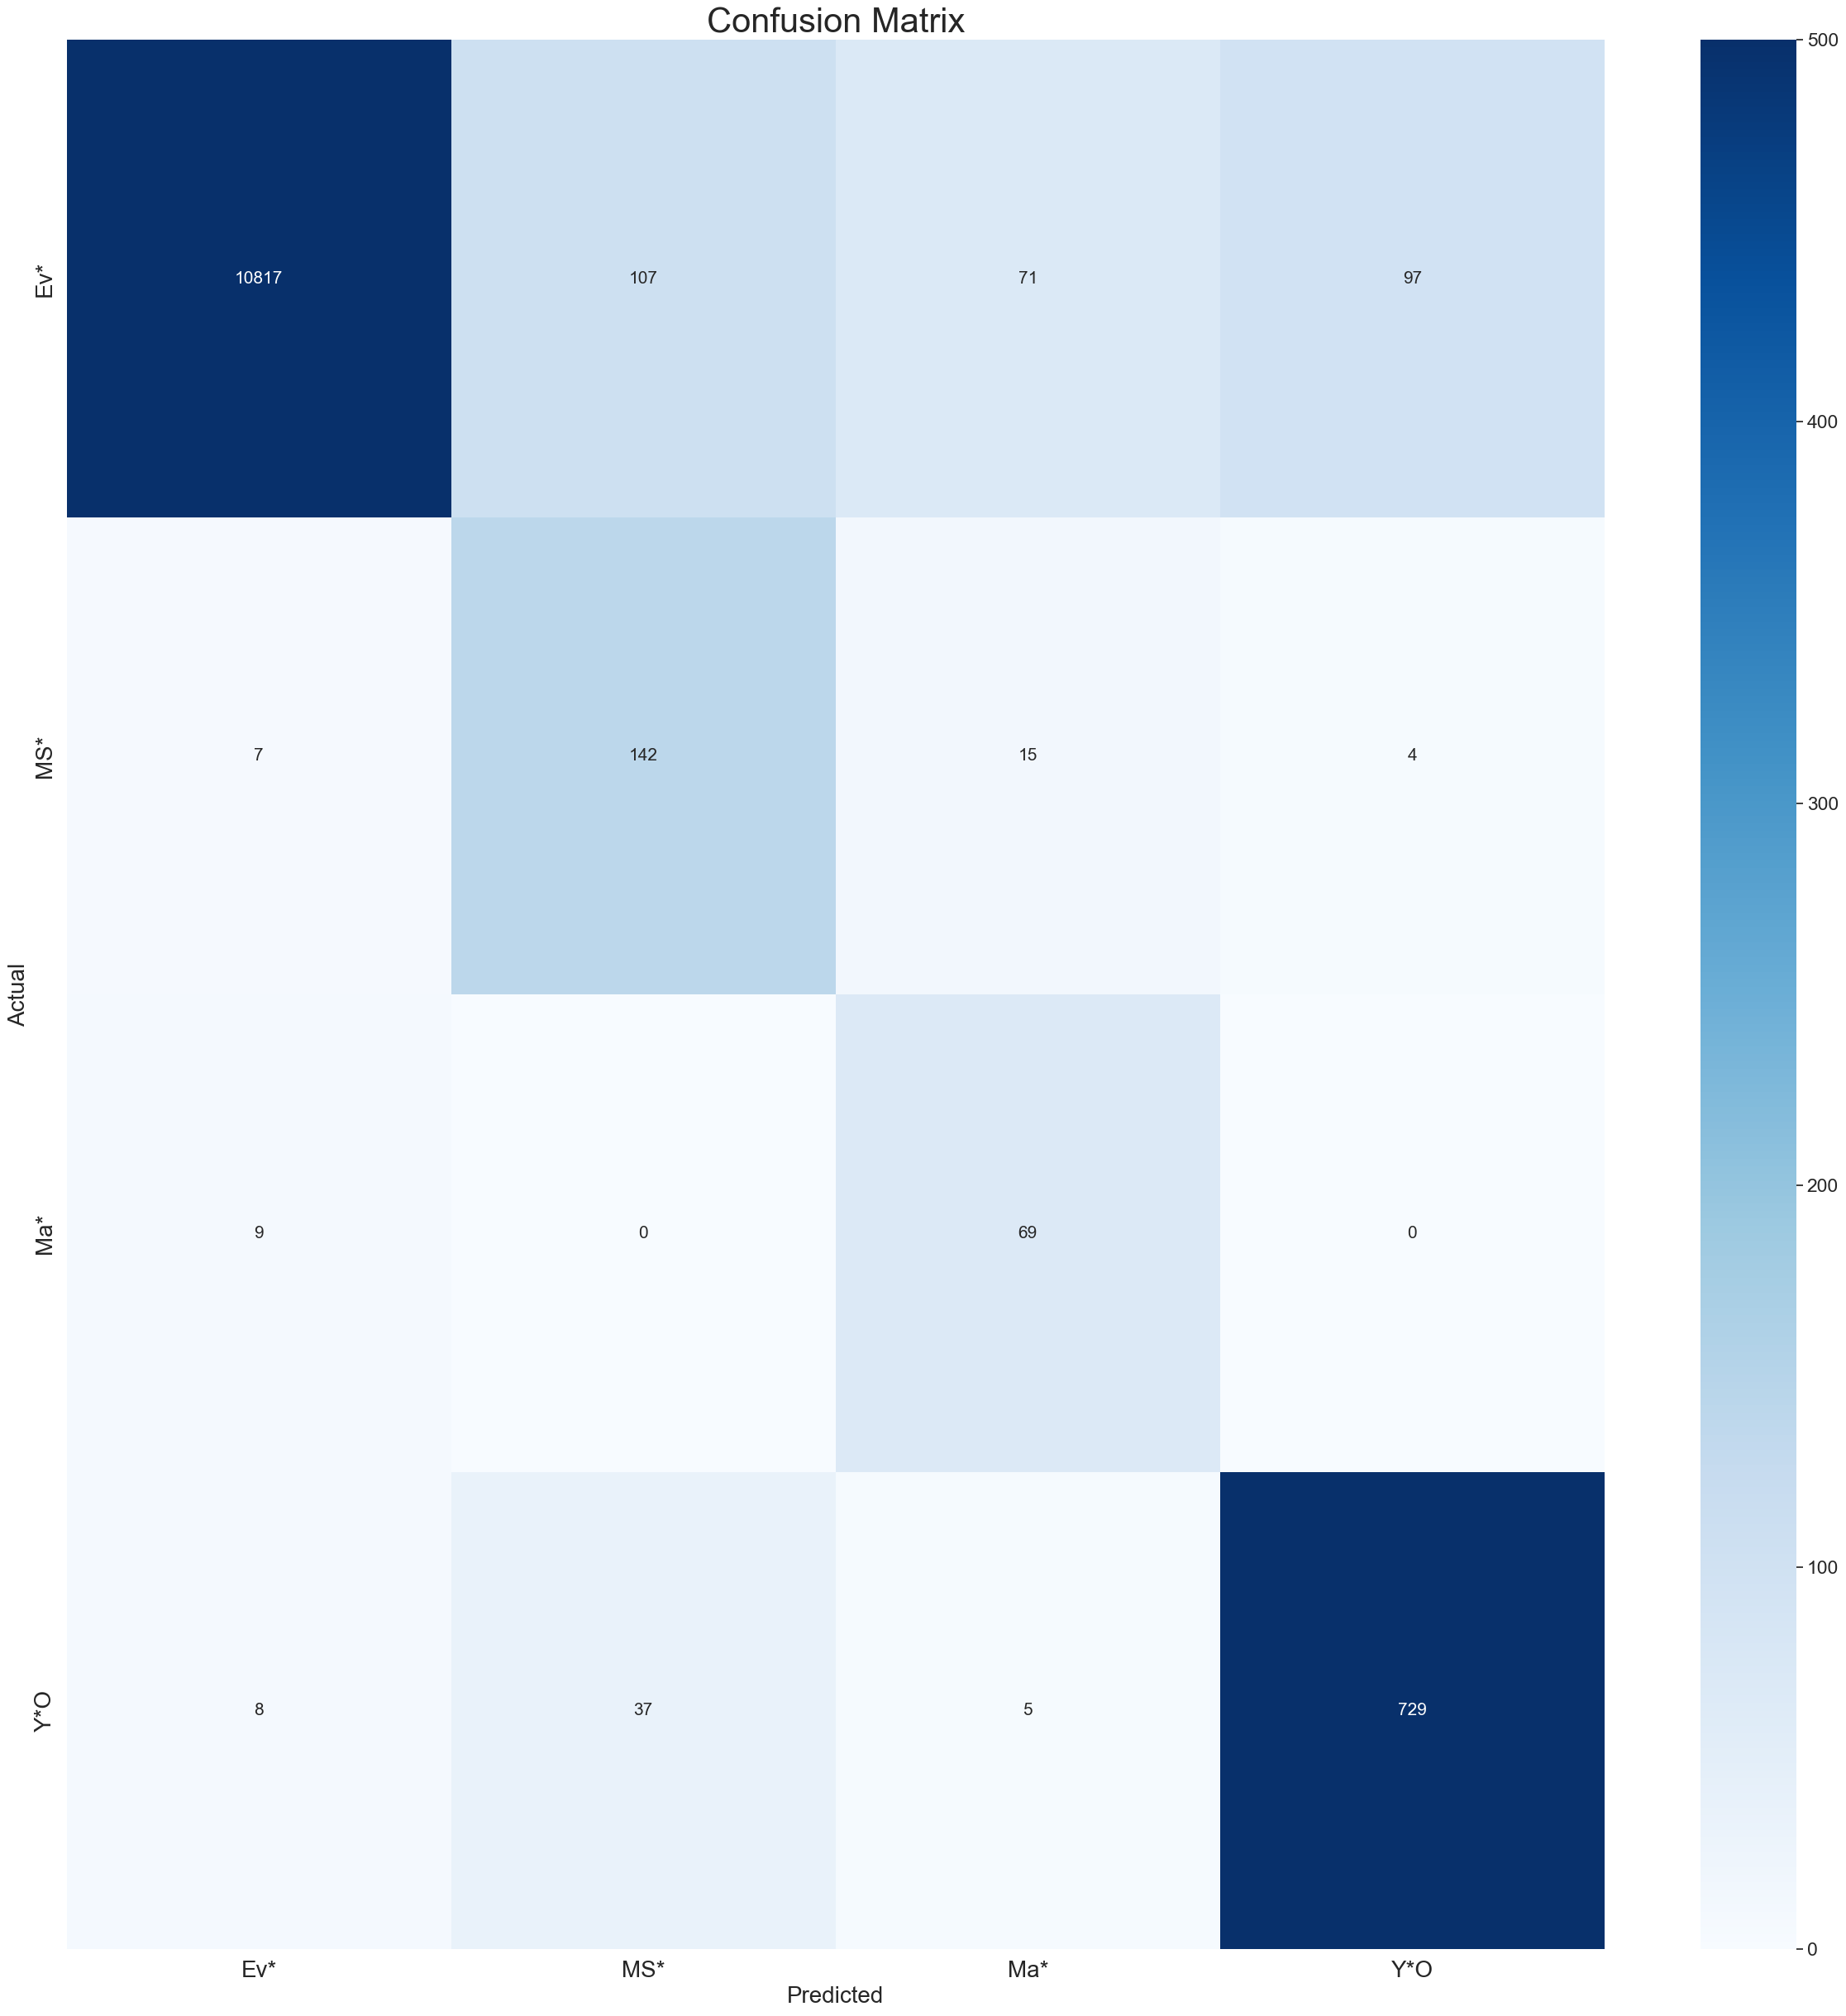

In [3]:
# Load the saved model
model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(y_batch.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.categories_[0][unique_labels])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()